# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 05 probabilistic noise suppression methods
2023/04/14

- attached: 
    1. [`lab05.pdf`](lab05.pdf)
    1. [`lab05.md`](lab05.md)

----
### import packages, define analysis parameters and draw parameters, etc.

In [4]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

# display wav files
import IPython

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

---
### load speech and noise

오디오 파일들의 경로 정의

In [2]:
audioinputpath = '../audio'
outpath = 'out'

# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [3]:
speechfile = addpath(audioinputpath, 'gjang-kdigits0-3.wav')
noisefile  = addpath(audioinputpath, 'car.wav')
wnoisefile  = addpath(audioinputpath, 'car_wideband.wav')   # 넓은 주파수 대역에 분포한 잡음

__load files in windows wav format__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [7]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
wnoise, _ = librosa.load(wnoisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speechfile, speech.shape, speech)
print(noisefile, noise.shape, noise)
print(wnoisefile, wnoise.shape, wnoise)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

../audio/gjang-kdigits0-3.wav (37952,) [-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04]
../audio/car.wav (175745,) [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
../audio/car_wideband.wav (175745,) [-0.05984497 -0.14807129 -0.14700317 ... -0.10241699 -0.10253906
 -0.09594727]
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


array([[  3.43608106,   6.52668654,   6.4201852 , ...,  -3.22208712,
        -12.109726  ,  -4.36789082],
       [ 16.55197942,  18.74696753,  18.31199222, ...,  19.0139984 ,
         19.83277802,  20.39343026],
       [ 17.40766666,  20.26121289,  22.16222055, ...,  23.42829917,
         24.75091936,  23.02823122],
       ...,
       [-38.4390941 , -34.7011153 , -44.66451486, ..., -43.87783998,
        -66.51596708, -37.96959437],
       [-39.0657465 , -35.03712344, -45.91154493, ..., -44.16382711,
        -67.00779024, -38.02013985],
       [-38.56792469, -34.81379091, -44.87832819, ..., -43.44395922,
        -78.27134367, -38.10852218]])

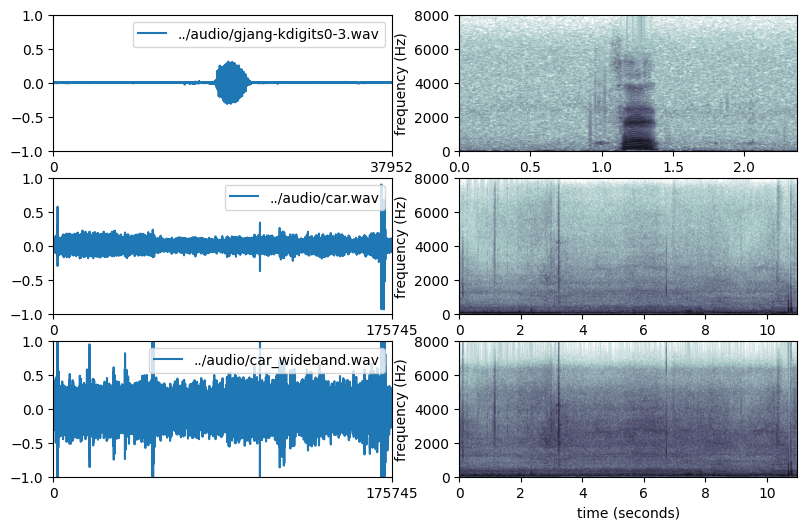

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.2,2.0]))

def plotsignal(s, lab):
    plt.plot(s, label=lab)
    plt.xlim(0,len(s)); plt.ylim(-1,1)
    plt.xticks([0, len(s)])
    plt.legend(loc='upper right')

plt.subplot(3,2,1)
plotsignal(speech, speechfile)
plt.subplot(3,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

plt.subplot(3,2,3)
plotsignal(noise, noisefile)
plt.subplot(3,2,4)
drawspectrogram3(noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

plt.subplot(3,2,5)
plotsignal(wnoise, wnoisefile)
plt.subplot(3,2,6)
drawspectrogram3(wnoise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

In [5]:
IPython.display.Audio(speechfile)

In [6]:
IPython.display.Audio(noisefile)

In [7]:
IPython.display.Audio(wnoisefile)

__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

In [10]:
def generate_mixed_signals(speech, noise, SNRs, isdraw=False):
    std_s = np.sqrt(np.mean(speech**2))
    std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
    mixedSig = []
    for snr in mixsnrs:
        gain = np.power(10, -snr/20)
        gn = noise[:len(speech)]/std_n*std_s*gain
        m = speech + gn
        mixedSig.append(m)
        print('Target SNR = %.0f dB, gain = %.2f, Mixing SNR=%.2f' % (snr, gain,10*np.log10(np.sum(speech**2)/np.sum(gn**2))))

        # draw
        if isdraw:
            plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
            plt.subplot(1,2,1)
            xscale = np.arange(len(gn))/Fs
            plt.plot(xscale,gn); plt.plot(xscale,speech); plt.xlim(0,len(speech)/Fs); plt.ylim(-0.5,0.5)  #; plt.xticks([])
            plt.title('SNR = %.0f dB' % (snr))
            plt.subplot(1,2,2)
            drawspectrogram3(m, Fs, Nf, Ns, minpercentile=1, colormap=cmap_plot)

    return mixedSig

############################
mixsnrs = np.array([20, 10, 0, -10])
mixedSig1 = generate_mixed_signals(speech, noise, mixsnrs, False)
mixedSig2 = generate_mixed_signals(speech, wnoise, mixsnrs, False)

Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00
Target SNR = 20 dB, gain = 0.10, Mixing SNR=20.00
Target SNR = 10 dB, gain = 0.32, Mixing SNR=10.00
Target SNR = 0 dB, gain = 1.00, Mixing SNR=-0.00
Target SNR = -10 dB, gain = 3.16, Mixing SNR=-10.00


---
## Programming assignments: implementating probabilistic noise suppression methods

### 1. probabilstic voice activity detection (VAD) for noise spectrum estimation
    - fixed thresholding 으로 noise 구간을 구하면 noise 의 크기에 크게 
    영향받을 수 밖에 없다. 따라서 noise 구간을 유연하게 추정할 수 있는
    (adaptive thresholding) 확률 모델을 사용하여 본다.

    1. 확률 모델을 이용하여 probabilistic voice activity detection 수행
    2. 각 frame 별로 noise 확률 계산 - find P(voice|y), y 는 한 frame 
    3. (deterministic decision) 확률값을 thresholding 하여 binary classification, 그리고 검출된 noise frame 들의 평균 제곱 Fourier 성분으로 noise spectrum 예측 
    4. (soft decision and maximum a posteriori estimation) 각 frame 별로 posterior probability ( P( voice | y ) ) 를 계산함. 그리고 noise spectrum 을 posterior probability로 weighted estimation 한다.  E[N] = sum (1-P(v|y)) y
    5. 두 가지 방법(deterministic/soft)으로 추정한 noise spectrum 으로 suppression 한 결과 비교 
    6. noise 차감은 lab04 의 time-domain Wiener filtering 이용

---
### 2. time domain VAD
    1. time domain signal 에 대해서 dual Gaussian mixture model 을 이용하여 probabilistic voice activity detection 
    2. speech 의 크기가 noise 의 크기보다 작다고 가정하고 
    작은 Gaussian 을 noise 분포로 가정 
    3. P(noise|y) = p(noise) p(y|noise), y 는 한 frame

__Speech and noise distribution__

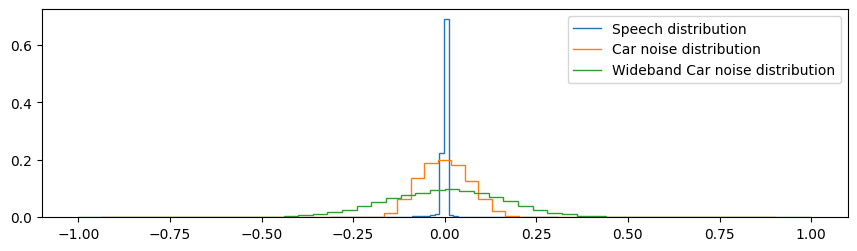

In [11]:
def plot_relative_hist(x, bins, lab=''):
    # plt.hist(x, bins=50)   # 개수를 보여준다. 확률은 아래와 같이 
    counts, bins = np.histogram(x, bins=50)
    fcounts = counts / len(x)
    plt.stairs(fcounts, bins, label=lab)
    return None

plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
plot_relative_hist(speech, bins=50, lab='Speech distribution')
plot_relative_hist(noise, bins=50, lab='Car noise distribution')
plot_relative_hist(wnoise, bins=50, lab='Wideband Car noise distribution')
plt.legend(loc='upper right')

mixed signal 도 그려보자

Text(0.5, 1.0, '../audio/gjang-kdigits0-3.wav + ../audio/car_wideband.wav')

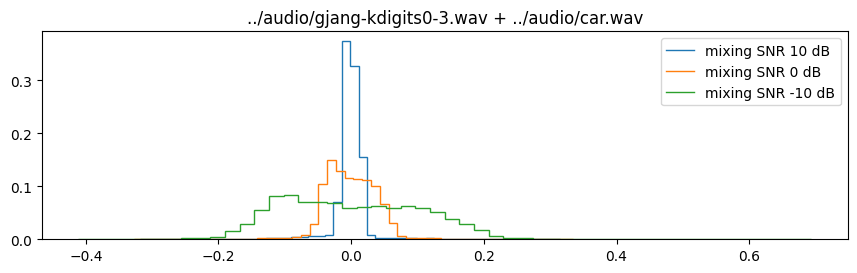

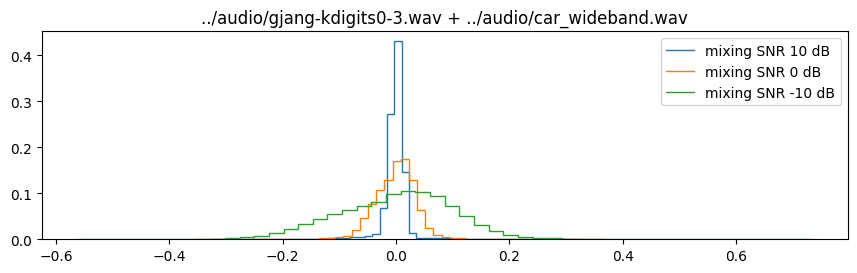

In [16]:
plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig1[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + noisefile)

plt.figure(figsize=FIG_SIZE*np.array([1.3,0.9]))
for i in range(1,4):
    plot_relative_hist(mixedSig2[i], bins=50, lab='mixing SNR %.0f dB'%(mixsnrs[i]))
plt.legend(loc='upper right')
plt.title(speechfile + ' + ' + wnoisefile)

## End of Lab 05